In [1]:
import argparse
import pickle
import torch
import os
import glob
import re

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import pandas as pd
if platform == "darwin":
    import matplotlib as mpl
    mpl.use("Qt5Agg")

from beautifultable import BeautifulTable
from sys import platform
from pathlib import Path
from incremental_rl.train import IncrementalExpt, set_one_thread


# colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colors = dict(mcolors.BASE_COLORS, **mcolors.XKCD_COLORS)
colors = list(colors.keys())
colors.remove('w')

/home/vasan/src/rtrl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'platform' is not defined

In [ ]:
# Plots hits vs timeouts

### Configurable params
env = "acrobot"
bp = "/home/vasan/src/rl_suite/rl_suite/plot"
fp = bp + f"/{env}_random_stat.txt"
###

df = pd.DataFrame(columns=["timeout", "seed", "hits"])
with open(fp, 'r') as file:
    for line in file.readlines():
        match = re.match(r"timeout=(\d+), seed=(\d+): (\d+)", line)
        timeout = match.group(1)
        seed = match.group(2)
        hits = match.group(3)
        df = pd.concat([df, pd.DataFrame.from_records([{'timeout': int(timeout), 'seed':int(seed), 'hits': int(hits)}])])
        
plt.title(env)
plt.xlabel('Timeout')
plt.ylabel('Hits')
ax = sns.barplot(data=df, x='timeout', y='hits')

# Labels over each bar
# ax.bar_label(ax.containers[0], fmt="%.2f", label_type="center")
    
# plt.savefig(f'{env}.png')
plt.show()
plt.close()


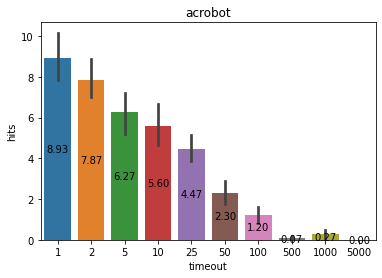

In [ ]:
import matplotlib.pyplot as plt

color_dict = {
    # simulation colors
    1:      'tab:blue',
    2:      'tab:orange',
    5:      'tab:green',
    10:     'tab:red',
    25:     'tab:purple', 
    50:     'tab:brown', 
    100:    'tab:pink', 
    500:    'tab:gray', 
    1000:   'tab:olive', 
    5000:   'tab:cyan',
    # real robot colors
    '3s':      'tab:blue',
    '6s':      'tab:orange',
    '15s':     'tab:red',
    '30s':     'tab:green',
}

def human_format_numbers(num, use_float=False):
    # Make human readable short-forms for large numbers
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    if use_float:
        return '%.2f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])
    return '%d%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])

def setsizes():
    plt.rcParams['axes.linewidth'] = 1.0
    plt.rcParams['lines.markeredgewidth'] = 1.0
    plt.rcParams['lines.markersize'] = 3

    plt.rcParams['xtick.labelsize'] = 14.0
    plt.rcParams['ytick.labelsize'] = 14.0
    plt.rcParams['xtick.direction'] = "out"
    plt.rcParams['ytick.direction'] = "in"
    plt.rcParams['lines.linewidth'] = 3.0
    plt.rcParams['ytick.minor.pad'] = 50.0

    # https://tex.stackexchange.com/questions/18687/how-to-generate-pdf-without-any-type3-fonts
    plt.rcParams['pdf.fonttype'] = 42   

def setaxes():
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.gcf().subplots_adjust(left=0.2)
    ax = plt.gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    # ax.spines['left'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(axis='both', direction='out', which='minor', width=2, length=3,
                   labelsize=12, pad=8)
    ax.tick_params(axis='both', direction='out', which='major', width=2, length=8,
                   labelsize=12, pad=8)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    for tick in ax.xaxis.get_major_ticks():
        # tick.label.set_fontsize(getxticklabelsize())
        tick.label.set_fontsize(14)
    for tick in ax.yaxis.get_major_ticks():
        # tick.label.set_fontsize(getxticklabelsize())
        tick.label.set_fontsize(14)

def set_curves():
    setsizes()
    setaxes()

def set_labels(title, xlabel="Timesteps", ylable="Return"):
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    h = plt.ylabel(ylable, fontsize=14, labelpad=25)
    h.set_rotation(0)
    (ticks, texts) = plt.xticks()
    try:
        new_labels = [human_format_numbers(int(k.get_text())) for k in texts]
    except:
        new_labels = [human_format_numbers(int(k)) for k in ticks]
    plt.xticks(ticks=ticks, labels=new_labels)
    plt.grid()
    plt.tight_layout()
